# Transport costs

## 📖 Ahead of time...

## 💻 Hands-on coding

In [1]:
import momepy
import geopandas
import contextily
import xarray, rioxarray
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ox.settings.overpass_settings = (
    '[out:json][timeout:90][date:"2021-03-07T00:00:00Z"]'
)

### *Moving* along (street) networks


````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
streets = geopandas.read_file("../data/arturo_streets.gpkg")
abbs = geopandas.read_file("../data/madrid_abb.gpkg")
neis = geopandas.read_file("../data/neighbourhoods.geojson")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
streets = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/67d5480f98453027d59bf49606a7ad92/arturo_streets.gpkg"
)
abbs = geopandas.read_file(
    "https://github.com/GDSL-UL/san/raw/v0.1.0/data/assignment_1_madrid/madrid_abb.gpkg"
)
neis = geopandas.read_file(
    "http://darribas.org/gds4ae/_downloads/44b4bc22c042386c2c0f8dc6685ef17c/neighbourhoods.geojson"
)
```
````


In [3]:
streets = geopandas.read_file("../data/arturo_streets.gpkg")
abbs = geopandas.read_file("../data/madrid_abb.gpkg")
neis = geopandas.read_file("../data/neighbourhoods.geojson")

#### `pandana` graphs

In [4]:
import pandana

Before building the routing network, we convert to graph and back in `momepy` to "clean" the network and ensure it complies with requirements for routing.

In [5]:
%%time
nodes, edges = momepy.nx_to_gdf( # Convert back to geo-table
    momepy.gdf_to_nx(            # Convert to a clean NX graph
        streets.explode(index_parts='True')        # We "explode" to avoid multi-part rows
    )
)
nodes = nodes.set_index("nodeID")# Reindex nodes on ID

CPU times: user 4.9 s, sys: 56.2 ms, total: 4.96 s
Wall time: 5 s


Once we have nodes and edges "clean" from the graph representation, we can build a `pandana.Network` object we will use for routing:

In [6]:
streets_pdn = pandana.Network(
    nodes.geometry.x,
    nodes.geometry.y,
    edges["node_start"],
    edges["node_end"],
    edges[["mm_len"]]
)

streets_pdn

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 49985
Setting CH edge vector of size 66499
Range graph removed 444 edges of 132998
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


#### Shortest-path routing

*How do I go from A to B?*

For example, from the first Airbnb in the geo-table...

In [7]:
first = abbs.loc[[0], :].to_crs(streets.crs)

...to Puerta del Sol.

In [8]:
import geopy
geopy.geocoders.options.default_user_agent = "gds4ae"
sol = geopandas.tools.geocode(
    "Puerta del Sol, Madrid", geopy.Nominatim
).to_crs(streets.crs)
sol

,geometry,address
0,POINT (440284.049 4474264.421),"Puerta del Sol, Barrio de los Austrias, Sol, C..."


First we *snap* locations to the network:

In [9]:
pt_nodes = streets_pdn.get_node_ids(
    [first.geometry.x.iloc[0], sol.geometry.x.iloc[0]], 
    [first.geometry.y.iloc[0], sol.geometry.y.iloc[0]]
)
pt_nodes

0     3071
1    35729
Name: node_id, dtype: int64

Then we can route the shortest path:

In [10]:
route_nodes = streets_pdn.shortest_path(
    pt_nodes[0], pt_nodes[1]
)
route_nodes

array([ 3071,  3476,  8268,  8266,  8267, 18695, 18693,  1432,  1430,
         353,  8175,  8176, 18121, 17476, 16858, 14322, 16857, 17810,
       44795, 41220, 41217, 41221, 41652, 18924, 18928, 48943, 18931,
       21094, 21095, 23219, 15398, 15399, 15400, 47446, 47447, 23276,
       47448, 23259, 23260, 23261, 27951, 27952, 27953, 48327, 11950,
       11949, 11944, 19475, 19476, 27333, 30088, 43294, 11940, 11941,
       11942, 48325, 37484, 48316, 15893, 15890, 15891, 29954, 25453,
        7341, 34991, 23608, 28217, 21648, 21649, 21651, 39075, 25108,
       25102, 25101, 25100, 48518, 47287, 34623, 31187, 29615, 48556,
       22844, 48553, 48555, 40922, 40921, 40923, 48585, 46372, 46371,
       46370, 45675, 45676, 38778, 38777, 19144, 20498, 20497, 20499,
       47737, 42303, 42302, 35730, 35727, 35729])

With this information, we can build the route line manually:

````{margin}
```{attention}
The code to generate the route involves writing a function and is a bit more advanced than expected for this course. If this looks too complicated, do not despair.

Also, please note this builds a *simplified* line for the route, not one that is based on the original geometries (distance calculations *are* based on the original network).
```
````

In [11]:
from shapely.geometry import LineString

def route_nodes_to_line(nodes, network):
    pts = network.nodes_df.loc[nodes, :]
    s = geopandas.GeoDataFrame(
        {"src_node": [nodes[0]], "tgt_node": [nodes[1]]},
        geometry=[LineString(pts.values)],
        crs=streets.crs
    )
    return s

We can calculate the route:

In [12]:
route = route_nodes_to_line(route_nodes, streets_pdn)

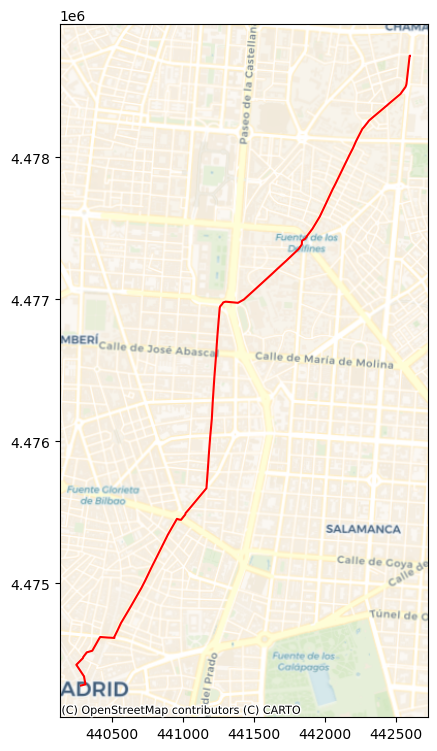

In [13]:
ax = route.plot(
    figsize=(9, 9),
    color="red"
)
contextily.add_basemap(
    ax, 
    crs=route.crs,
    source=contextily.providers.CartoDB.Voyager,
    zoom=14
)

And we get it back as a geo-table (with one row):

In [14]:
route

,src_node,tgt_node,geometry
0,3071,3476,"LINESTRING (442606.507 4478714.516, 442597.100..."


If we wanted to obtain the length of the route:

In [15]:
route_len = streets_pdn.shortest_path_length(
    pt_nodes[0], pt_nodes[1]
)
round(route_len / 1000, 3) # Dist in Km

5.458

```{admonition} Challenge
* What is the network distance between CEMFI and Puerta del Sol?
* BONUS I: how much longer is it than if you could fly in a straight line?
* BONUS II: if one walks at a speed of 5 Km/h, how long does the walk take you?
```

#### Weighted routing

*How do I go from A to B passing by the "best" buildings?*

This is really an extension of standard routing that takes advantage of the flexibility of `pandana.Network` objects.

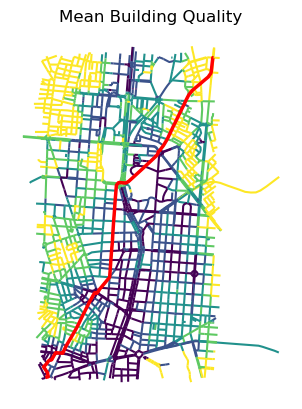

In [16]:
bb = route.total_bounds
ax = streets.cx[
    bb[0]: bb[2], bb[1]:bb[3]
].plot(
    "average_quality", scheme="quantiles"
)
route.plot(color="r", linewidth=2.5, ax=ax)
ax.set_title("Mean Building Quality")
ax.set_axis_off();

The overall process is the same; the main difference is, when we build the `Network` object, to replace distance (`mm_len`) with a measure that *combines* distance and building quality. Note that we want to *maximise* building quality, but the routing algorithms use a *minimisation* function. Hence, our composite index will need to reflect that.

The strategy is divided in the following steps:

1. Re-scale distance between 0 and 1
1. Build a measure inverse to building quality in the $[0, 1]$ range
1. Generate a combined measure (`wdist`) by picking a weighting parameter
1. Build a new `Network` object that incorporates `wdist` instead of distance
1. Compute route between the two points of interest

For 1., we can use the scaler in `scikit-learn`:

In [17]:
from sklearn.preprocessing import minmax_scale

Then generate and attach to `edges` a scaled version of `mm_len`:

In [18]:
edges["scaled_dist"] = minmax_scale(edges["mm_len"])

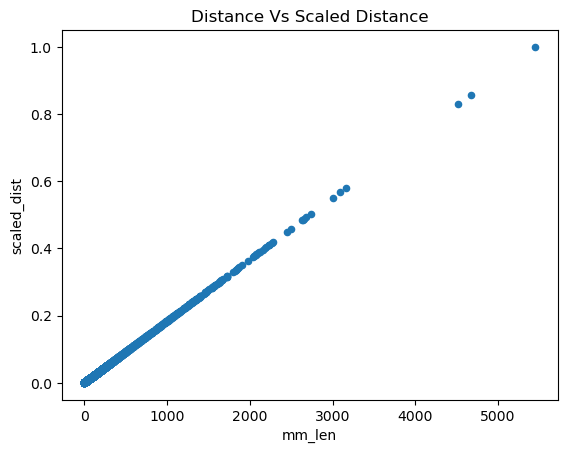

In [19]:
ax = edges.plot.scatter("mm_len", "scaled_dist")
ax.set_title("Distance Vs Scaled Distance");

We move on to 2., with a similar approach. We will use the negative of the building quality average (`average_quality`):

In [20]:
edges["scaled_inv_bquality"] = minmax_scale(
    -edges["average_quality"]
)

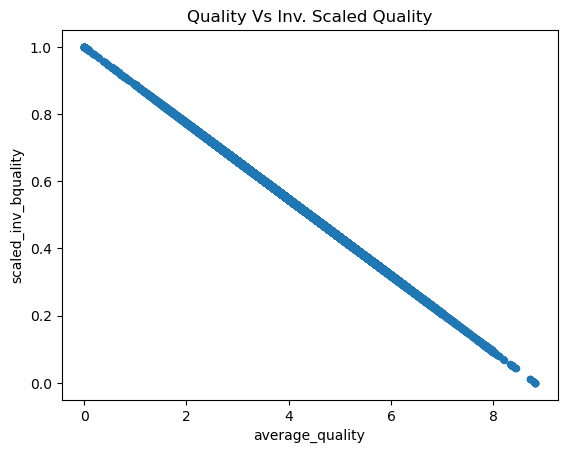

In [21]:
ax = edges.plot.scatter(
    "average_quality", "scaled_inv_bquality"
)
ax.set_title("Quality Vs Inv. Scaled Quality");

Taking 1. and 2. into 3. we can build `wdist`. For this example, we will give each dimension the same weight (0.5), but this is at discretion of the researcher.

In [22]:
w = 0.5
edges["wdist"] = (
    edges["scaled_dist"] * w +
    edges["scaled_inv_bquality"] * (1-w)
)

Now we can recreate the `Network` object based on our new measure (4.) and provide routing. Since it is the same process as with distance, we will do it all in one go:

In [23]:
# Build new graph object
w_graph = pandana.Network(
    nodes.geometry.x,
    nodes.geometry.y,
    edges["node_start"],
    edges["node_end"],
    edges[["wdist"]]
)
# Snap locations to their nearest node
pt_nodes = w_graph.get_node_ids(
    [first.geometry.x.iloc[0], sol.geometry.x.iloc[0]], 
    [first.geometry.y.iloc[0], sol.geometry.y.iloc[0]]
)
# Generate route
w_route_nodes = w_graph.shortest_path(
    pt_nodes[0], pt_nodes[1]
)
# Build LineString
w_route = route_nodes_to_line(
    w_route_nodes, w_graph
)

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 49985
Setting CH edge vector of size 66499
Range graph removed 444 edges of 132998
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Now we are ready to display it on a map:

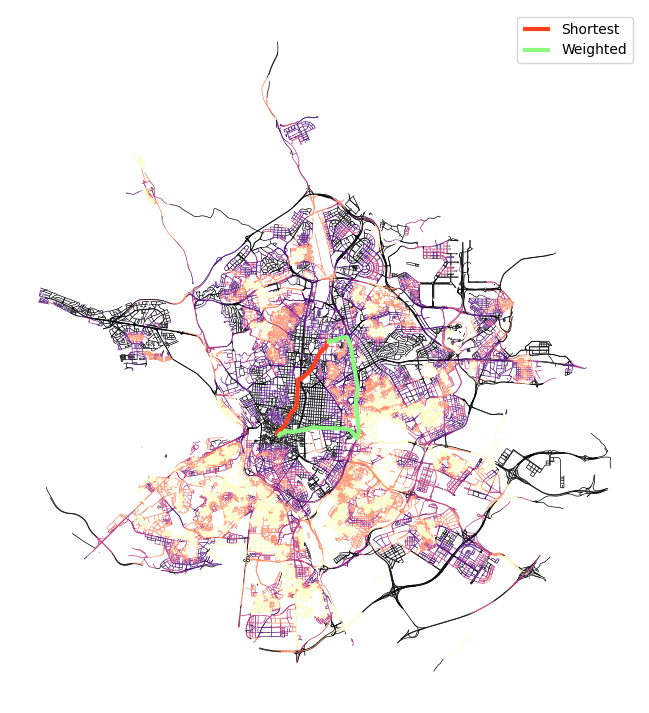

In [24]:
# Building quality
ax = streets.plot(
    "average_quality", 
    scheme="quantiles", 
    cmap="magma",
    linewidth=0.5,
    figsize=(9, 9)
)
# Shortest route
route.plot(
    color="xkcd:orange red", linewidth=3, ax=ax, label="Shortest"
)
# Weighted route
w_route.plot(
    color="xkcd:easter green", linewidth=3, ax=ax, label="Weighted"
)
# Styling
ax.set_axis_off()
plt.legend();

```{admonition} Challenge
1. Explore the differences in the output of weighted routing if you change the weight between distance and the additional constrain.
2. Recreate weighted routing using the linearity of street segments. How can you go from A to B avoiding long streets?
```

#### Proximity

*What is the nearest internet cafe for Airbnb's without WiFi?*

First we identify Airbnb's without WiFi:

In [25]:
no_wifi = abbs.query(
    "WiFi == '0'"
).to_crs(streets.crs)

Then pull WiFi spots in Madrid from OpenStreetMap:

In [26]:
icafes = ox.features_from_place(
    "Madrid, Spain", tags={"amenity": "internet_cafe"}
).to_crs(streets.crs).reset_index()

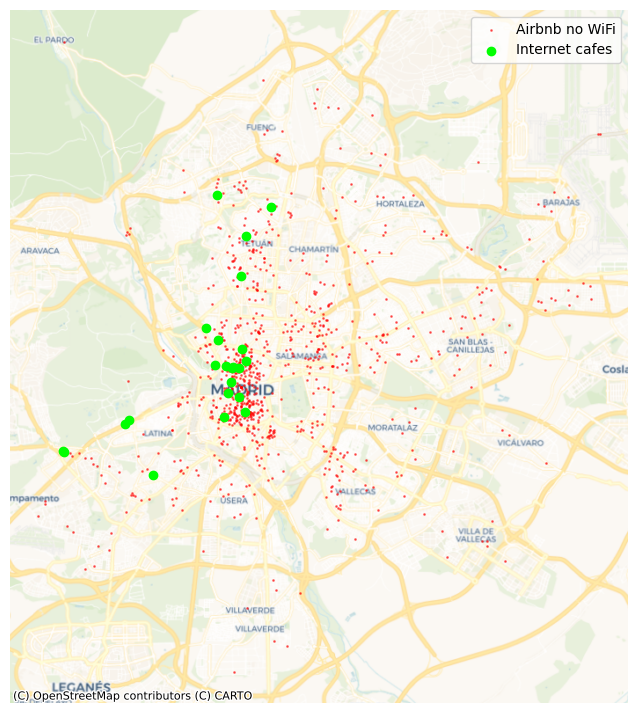

In [27]:
ax = no_wifi.plot(
    color="red", 
    markersize=1,
    alpha=0.5,
    label="Airbnb no WiFi",
    figsize=(9, 9)
)
icafes.plot(
    ax=ax, color="lime", label="Internet cafes"
)
contextily.add_basemap(
    ax, 
    crs=no_wifi.crs,
    source=contextily.providers.CartoDB.Voyager
)
ax.set_axis_off()
plt.legend()
plt.show()

The logic for this operation is the following:

1. Add the points of interest (POIs, the internet cafes) to the network object (`streets_pdn`)
1. Find the nearest node to each POI
1. Find the nearest node to each Airbnb without WiFi
1. Connect each Airbnb to its nearest internet cafe

We can add the internet cafes to the network object (1.) with the `set_pois` method:

```{margin}
Note we set `maxitems=1` because we are only going to query for the nearest cafe. This will make computations much faster
```

In [28]:
streets_pdn.set_pois(
    category="Internet cafes", # Our name for the layer in the `Network` object
    maxitems=1,                # Use to count only nearest cafe
    maxdist=100000,            # 100km so everything is included
    x_col=icafes.geometry.x,   # X coords of cafes
    y_col=icafes.geometry.y,   # Y coords of cafes
)

Once the cafes are added to the network, we can find the nearest one to each node (2.):

```{margin}
Note there are some nodes for which we can't find a nearest cafe. These are related to disconnected parts of the network
```

In [29]:
cafe2nnode = streets_pdn.nearest_pois(
    100000,              # Max distance to look for
    "Internet cafes",    # POIs to look for
    num_pois=1,          # No. of POIs to include
    include_poi_ids=True # Store POI ID
).join(# Then add the internet cafee IDs and name
    icafes[['osmid', 'name']],
    on="poi1"
).rename(# Rename the distance from node to cafe
    columns={1: "dist2icafe"}
)
cafe2nnode.head()

,dist2icafe,poi1,osmid,name
nodeID,,,,
0,5101.421875,9.0,3.770327e+09,Silver Envíos 2
1,5190.265137,9.0,3.770327e+09,Silver Envíos 2
2,5252.475098,9.0,3.770327e+09,Silver Envíos 2
3,5095.101074,9.0,3.770327e+09,Silver Envíos 2
4,5676.117188,9.0,3.770327e+09,Silver Envíos 2


Note that, to make things easier down the line, we can link `cafe2nnode` to the cafe IDs.

And we can also link Airbnb's to nodes (3.) following a similar approach as we have seen above:

In [30]:
abbs_nnode = streets_pdn.get_node_ids(
    no_wifi.geometry.x, no_wifi.geometry.y
)
abbs_nnode.head()

26      8872
50     10905
62     41158
63     34257
221    32215
Name: node_id, dtype: int64

Finally, we can bring together both to find out what is the nearest internet cafe for each Airbnb (4.):

In [31]:
abb_icafe = no_wifi[
    ["geometry"]     # Keep only geometries of ABBs w/o WiFi
].assign(
    nnode=abbs_nnode # Attach to thse ABBs the nearest node in the network
).join(              # Join to each ABB the nearest cafe using node IDs
    cafe2nnode, 
    on="nnode"
)
abb_icafe.head()

,geometry,nnode,dist2icafe,poi1,osmid,name
26,POINT (443128.256 4483599.841),8872,4926.223145,9.0,3.770327e+09,Silver Envíos 2
50,POINT (441885.677 4475916.602),10905,1876.392944,19.0,6.922981e+09,Locutorio
62,POINT (440439.640 4476480.771),41158,1164.812988,17.0,5.573414e+09,NaN
63,POINT (438485.311 4471714.377),34257,1466.537964,5.0,2.304485e+09,NaN
221,POINT (439941.104 4473117.914),32215,354.268005,15.0,5.412145e+09,NaN


```{admonition} Challenge
Calculate distances to nearest internet cafe for ABBs *with* WiFi. On average, which of the two groups (with and without WiFi) are closer to internet cafes?
```

#### Accessibility

This flips the previous question on its head and, instead of asking what is the nearest POI to a given point, along the network (irrespective of distance), it asks *how many POIs can I access within a network-based distance radious?*

In [32]:
%%time
parks = ox.features_from_place(
    "Madrid, Spain", tags={"leisure": "park"}
).to_crs(streets.crs)

CPU times: user 551 ms, sys: 13.9 ms, total: 564 ms
Wall time: 575 ms


*How many parks are within 500m(-euclidean) of an Airbnb?*

We draw a radious of 500m around each AirBnb:

In [33]:
buffers = geopandas.GeoDataFrame(
    geometry=abbs.to_crs(
        streets.crs
    ).buffer(
        500
    )
)

Then intersect it with the location of parks, and count by buffer (ie. Airbnb):

In [34]:
park_count = geopandas.sjoin(
    parks, buffers
).groupby(
    "index_right"
).size()

*How many parks are within 500m(-network) of an Airbnb?*

We need to approach this as a calculation *within* the network. The logic of steps thus looks like:

1. Use the aggregation module in `pandana` to count the number of parks within 500m of each node in the network
1. Extract the counts for the nodes nearest to Airbnb properties
1. Assign park counts to each Airbnb


We can set up the aggregate engine (1.). This involves three steps: 

a. Obtain nearest node for each park

In [35]:
parks_nnode = streets_pdn.get_node_ids(
    parks.centroid.x, parks.centroid.y
)

b. Insert the parks' nearest node through `set` so it can be "aggregated"


In [36]:
streets_pdn.set(
    parks_nnode, name="Parks"
)

c. "Aggregate" for a distance of 500m, effectively counting the number of parks within 500m of each node

In [37]:
parks_by_node = streets_pdn.aggregate(
    distance=500, type="count", name="Parks"
)
parks_by_node.head()

nodeID
0    5.0
1    5.0
2    6.0
3    8.0
4    1.0
dtype: float64

At this point, we have the number of parks within 500m of *every* node in the network. To identify those that correspond to each Airbnb (3.), we first pull out the nearest nodes to each ABB:

In [38]:
abbs_xys = abbs.to_crs(streets.crs).geometry
abbs_nnode = streets_pdn.get_node_ids(
    abbs_xys.x, abbs_xys.y
)

And use the list to asign the count of the nearest node to each Airbnb:

In [39]:
park_count_network = abbs_nnode.map(
    parks_by_node
)
park_count_network.head()

0     4.0
1     9.0
2     5.0
3     0.0
4    12.0
Name: node_id, dtype: float64

*For which areas do both differ most?*

We can compare the two counts above to explore to what extent the street layout is constraining access to nearby parks.

In [40]:
park_comp = geopandas.GeoDataFrame(
    {
        "Euclidean": park_count, 
        "Network": park_count_network
    },
    geometry=abbs.geometry,
    crs=abbs.crs
)

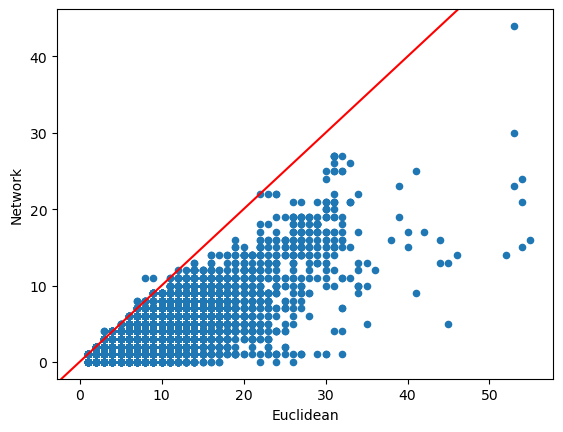

In [41]:
ax = park_comp.plot.scatter("Euclidean", "Network")
ax.axline([0, 0], [1, 1], color='red');# 45deg line

And, geographically:

```{margin}
Note there are a few cases where there are more network counts than Euclidean. These are due to the slight inaccuracies introduced by calculating network distances from nodes rather than the locations themselves
```

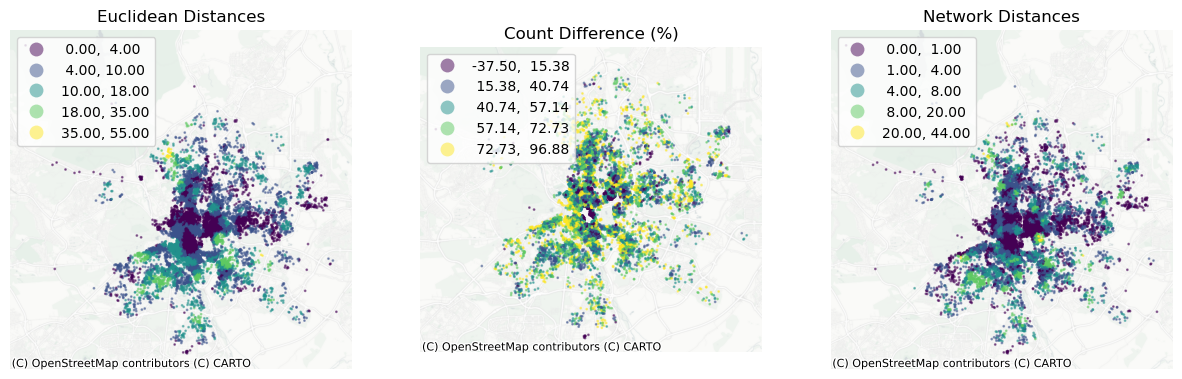

In [42]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))

# Euclidean count
abbs.to_crs(
    streets.crs
).assign(
    n_parks=park_count
).fillna(0).plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[0]
)
contextily.add_basemap(
    axs[0], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[0].set_axis_off()
axs[0].set_title("Euclidean Distances")

# Count difference
with_parks = park_comp.query(
    "(Network > 0) & (Euclidean > 0)"
)
count_diff = 100 * (
    with_parks["Euclidean"] - 
    with_parks["Network"]
) / with_parks["Euclidean"]
abbs.to_crs(
    streets.crs
).assign(
    n_parks=count_diff
).dropna().plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[1]
)
contextily.add_basemap(
    axs[1], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[1].set_axis_off()
axs[1].set_title("Count Difference (%)")

# Network count
abbs.to_crs(
    streets.crs
).assign(
    n_parks=park_count_network
).fillna(0).plot(
    "n_parks", 
    scheme="fisherjenkssampled", 
    alpha=0.5,
    markersize=1,
    figsize=(9, 9),
    legend=True,
    ax=axs[2]
)
contextily.add_basemap(
    axs[2], 
    crs=streets.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
axs[2].set_axis_off()
axs[2].set_title("Network Distances")

plt.show()

```{admonition} Challenge
Calculate accessibility to _other_ ABBs from each ABB through the network. *How many ABBs can you access within 500m of each ABB?*

Note you will need to use the locations of ABBs both as the source and the target for routing in this case.
```

### Shortest-path along surfaces


````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
friction_walk = rioxarray.open_rasterio(
    "../data/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file("../data/cambodian_cities.geojson")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
friction_walk = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/481f40ab3d2922d5e00b084b3668314b/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/f41b238a4d072a8a3eb5ce1794cd126a/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/b2bc4ad46ffb5fcec467286c022adf14/cambodian_cities.geojson"
)
```
````


In [43]:
friction_walk = rioxarray.open_rasterio(
    "../data/cambodia_2020_walking_friction_surface.tif"
)
friction_motor = rioxarray.open_rasterio(
    "../data/cambodia_2020_motorized_friction_surface.tif"
)
cities = geopandas.read_file("../data/cambodian_cities.geojson")

```python
main_roads = ox.geometries_from_place(
    "Cambodia", tags={"highway": "trunk"}
)
```

In [44]:
# Try read locally
try:
    main_roads = geopandas.read_file("../data/cambodia_roads_cache.gpkg")
# Download/write otherwise
except:
    main_roads = ox.geometries_from_place(
        "Cambodia", tags={"highway": "trunk"}
    )
    main_roads.to_file(
        "../data/cambodia_roads_cache.gpkg", driver="GPKG"
    )

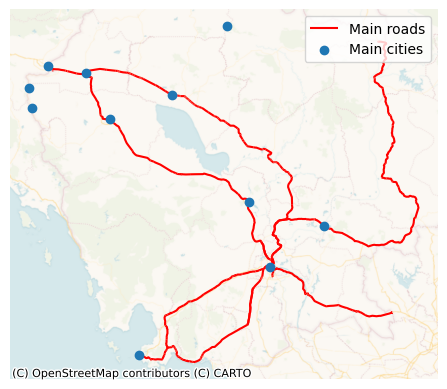

In [45]:
ax = main_roads.plot(
    color="red", label="Main roads"
)
cities.plot(
    ax=ax, zorder=2, label="Main cities"
)
contextily.add_basemap(
    ax, 
    crs=main_roads.crs, 
    source=contextily.providers.CartoDB.VoyagerNoLabels
)
ax.set_axis_off()
plt.legend();

From the geo-table of roads, we can generate a surface that has a value of 1 on cells where a road crosses, and 0 otherwise (*rasterisation*).

In [46]:
from geocube.api.core import make_geocube

roads_surface = make_geocube(
    main_roads.assign(
        one=1
    ).to_crs(epsg=3148),
    measurements=["one"],
    resolution=(500, 500)
)["one"]

Now we turn it into a binary mask:

In [47]:
road_mask = xarray.where(
    roads_surface.isnull(), 0, 1
)

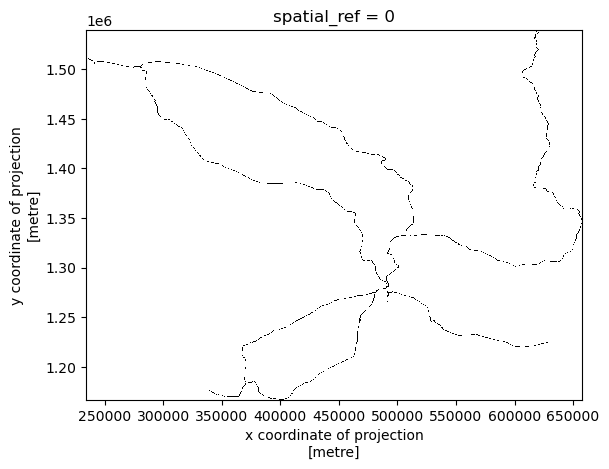

In [48]:
road_mask.plot(
    cmap="Greys", add_colorbar=False
);

In [49]:
road_mask

<xarray.DataArray 'one' (y: 745, x: 847)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y            (y) float64 1.167e+06 1.168e+06 ... 1.539e+06 1.539e+06
  * x            (x) float64 2.348e+05 2.352e+05 ... 6.572e+05 6.578e+05
    spatial_ref  int64 0

Then we can generate the routing from, say Phnom Penh to Poipet, using `xarray-spatial`'s A* algorithm:

In [50]:
from xrspatial import a_star_search

# Pull out starting point
start = cities.query(
    "UC_NM_MN == 'Phnom Penh'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Pull out ending point
end = cities.query(
    "UC_NM_MN == 'Poipet'"
).to_crs(
    epsg=3148
).squeeze().geometry

# Routing
route = a_star_search(
    road_mask,          # Road surface
    (start.y, start.x), # Starting point
    (end.y, end.x),     # Destination point
    barriers=[0],       # Cell values that cannot be crossed
    snap_start=True,    # Snap starting point to valid cells
    snap_goal=True      # Snap ending point to valid cells
)

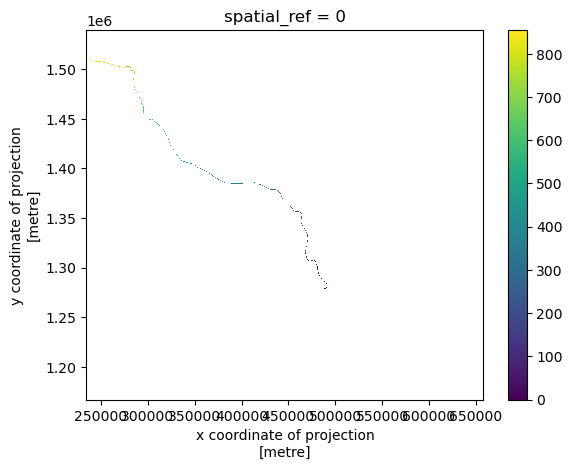

In [51]:
route.plot()

In [52]:
route

<xarray.DataArray (y: 745, x: 847)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1.167e+06 1.168e+06 ... 1.539e+06 1.539e+06
  * x            (x) float64 2.348e+05 2.352e+05 ... 6.572e+05 6.578e+05
    spatial_ref  int64 0

And we can turn the route surface into a line that connects the pixels in the route:

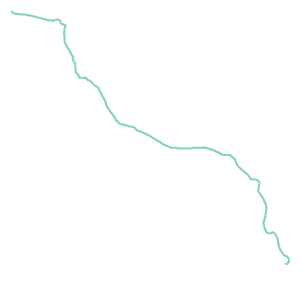

In [53]:
from shapely.geometry import LineString

route_line = LineString(
    route.to_series().dropna().reset_index().rename(
        columns={0: "order"}
    ).sort_values(
        "order"
    )[
        ["x", "y"]
    ].values
)
route_line

```{admonition} Challenge
Calculate the route between Battambang and Sihanoukville. *What is the distance?*
```

## 🐾 Next steps

If you found the content in this block useful, the following resources represent some suggestions on where to go next:

- The [`pandana` tutorial](https://github.com/UDST/pandana/blob/master/examples/Pandana-demo.ipynb) and [documentation](http://udst.github.io/pandana/index.html) are excellent places to get a more detailed and comprehensive view into the functionality of the library
- More about `xarray-spatial`, the library that provides geospatial techniques on top of surfaces is available at the project's [documentation](https://makepath.github.io/xarray-spatial/)